# Proyecto de Clasificación de Noticias Falsas en Español

Este notebook contiene la implementación de un modelo de Machine Learning para clasificar noticias como verdaderas o falsas. Se utilizan técnicas de procesamiento de lenguaje natural para analizar el contenido de los títulos y descripciones de las noticias.

*Estudiante 1:* Rodrigo Paz Londoño.
*Estudiante 2:*Juan José Murillo Aristizabal.
*Estudiante 3:* Manolo Hernandez Rojas.

## Instalación de Dependencias

Se instalan las bibliotecas necesarias para el procesamiento de texto y el modelado de Machine Learning.

In [1]:
!pip install seaborn
!pip install spacy
!pip install scikit-learn
!pip install nltk
!python -m spacy download es_core_news_sm
!python -m spacy download es_core_news_sm
!pip install joblib
!pip install tensorflow
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 8.4 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
  Using cached https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.8.0/es_core_news_sm-3.8.0-py3-none-any.whl (12.9 MB)
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


## Importación de Bibliotecas

Se importan las bibliotecas necesarias para el análisis de datos, procesamiento de texto y modelado.

In [2]:
import pandas as pd
import seaborn as sns
import re, unicodedata
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import  confusion_matrix
from nltk.corpus import stopwords
import spacy
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from joblib import dump, load
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model
import numpy as np


## Carga de Datos

Se carga el dataset con noticias en español desde un archivo CSV. Aseguramos que la columna de fecha esté en el formato adecuado.

In [3]:

# Uso de la libreria pandas para la lectura de archivos
data = pd.read_csv('/Users/juanjo/Library/CloudStorage/OneDrive-Universidaddelosandes/2025-01/BI/proyecto/fake_news_spanish.csv', sep=';', encoding='utf-8')
# Asignación a una nueva variable de los datos leidos
data_t = data


data_t["Fecha"] = pd.to_datetime(data_t["Fecha"], format="%d/%m/%Y")

print(data_t.head())


   ID  Label                                             Titulo  \
0  ID      1  'The Guardian' va con Sánchez: 'Europa necesit...   
1  ID      0  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2  ID      1  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3  ID      1  Iglesias alienta a Yolanda Díaz, ERC y EH Bild...   
4  ID      0  Puigdemont: 'No sería ninguna tragedia una rep...   

                                         Descripcion      Fecha  
0  El diario británico publicó este pasado jueves... 2023-06-02  
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ... 2023-10-01  
2  El valencianismo convoca en Castelló su fiesta... 2022-04-25  
3  En política, igual que hay que negociar con lo... 2022-01-03  
4  En una entrevista en El Punt Avui, el líder de... 2018-03-09  


## Exploración de Datos

Se examina la estructura de los datos para entender su composición y detectar valores nulos o inconsistencias.

In [4]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           57063 non-null  object        
 1   Label        57063 non-null  int64         
 2   Titulo       57047 non-null  object        
 3   Descripcion  57063 non-null  object        
 4   Fecha        57063 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.2+ MB


## Análisis de Correlación entre Fecha y Etiqueta

Convertimos la fecha en un valor numérico y analizamos su correlación con la etiqueta de veracidad de la noticia.

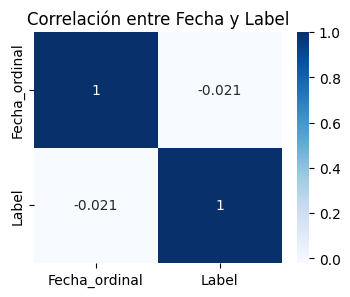

In [5]:

# Convertimos la fecha a ordinal
data_t['Fecha_ordinal'] = data_t['Fecha'].apply(lambda x: x.toordinal())

# Calculamos la matriz de correlación con Label
corr_matrix = data_t[['Fecha_ordinal', 'Label']].corr()

# Graficar la matriz de correlación
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlación entre Fecha y Label')
plt.show()

Se puede decir que la fecha no tiene una correlación relevante con la variable de interés "Label", por ello, se decide que no se incluirá en el modelo.

##Análisis de Longitud de Textos en Títulos y Descripciones

En esta sección, se realiza un análisis de la estructura de los textos en las noticias. Se calculan métricas clave sobre los títulos y descripciones para comprender mejor la distribución de palabras y su impacto en el modelo.

*   Relleno de valores nulos: Se reemplazan los valores faltantes en la columna 'Titulo' con una cadena vacía para evitar errores en el procesamiento.
*   Conteo de caracteres: Se calcula la longitud total de cada descripción y título.
*  Palabra más larga y más corta: Se extrae la longitud de la palabra más larga y más corta en cada descripción y título, lo que permite analizar la complejidad del vocabulario.

Este análisis proporciona información útil para entender la variabilidad en la longitud del texto, lo que puede influir en el rendimiento del modelo de clasificació




In [6]:
textos = data_t.copy()
# Rellenar NaN con cadena vacía para la columna 'Titulo'
textos['Titulo'] = textos['Titulo'].fillna("")
textos['Conteo Descripcion'] = [len(x) for x in textos['Descripcion']]
textos['Conteo Titulo'] = [len(x) for x in textos['Titulo']]
textos['Max Descripcion'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Descripcion']]
textos['Max Titulo'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Titulo']]
textos['Min Descripcion'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Descripcion']]
textos['Min Titulo'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Titulo']]

## Preprocesamiento de Texto

Se aplica procesamiento de texto utilizando spaCy para eliminar stopwords, realizar lematización y normalizar el texto, de igual forma se crean funciones con el fin de eliminar caracteres no ASCII, convertir todo a minuscula, remover puntuación, elminar palabras vacías.

In [7]:

# Descarga de stopwords en español (solo la primera vez)
nltk.download('stopwords')
def remove_non_ascii(words):
    """
    Elimina caracteres no ASCII de una lista de palabras tokenizadas.
    Nota: Esto removerá acentos y caracteres especiales del español.
    """
    new_words = []
    for word in words:
        if word is not None:
            new_word = unicodedata.normalize('NFKD', word)\
                      .encode('ascii', 'ignore')\
                      .decode('utf-8', 'ignore')
            new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """
    Convierte todos los caracteres a minúsculas a partir de una lista de palabras tokenizadas.
    """
    return [word.lower() for word in words if word is not None]

def remove_punctuation(words):
    """
    Elimina la puntuación de una lista de palabras tokenizadas.
    """
    new_words = []
    for word in words:
        if word is not None:
            # Se eliminan todos los caracteres que no sean letras, dígitos o espacios.
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """
    Elimina las palabras vacías (stopwords) de una lista de palabras tokenizadas usando
    la lista de stopwords en español de NLTK.
    """
    stop_words = set(stopwords.words('spanish'))
    return [word for word in words if word not in stop_words]

# Ejemplo de función de preprocesamiento que aplica los pasos anteriores
def preprocessing(words):
    """
    Aplica una serie de transformaciones a una lista de palabras tokenizadas:
      - Convertir a minúsculas.
      - Eliminar puntuación.
      - Eliminar caracteres no ASCII (opcional, cuidado con acentos).
      - Eliminar palabras vacías.
    """
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)   # Puedes comentar esta línea para conservar acentos.
    words = remove_stopwords(words)
    return words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/juanjo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Cargar el modelo de español
nlp = spacy.load("es_core_news_sm")

# Suponiendo que data_t es tu DataFrame y tiene la columna 'Descripcion'
# Definimos una función de preprocesamiento con spaCy
def preprocess_text(text):
    # Verificar que el texto no sea NaN
    if not isinstance(text, str):
        return ""
    doc = nlp(text)
    # Procesamos cada token:
    # - Convertimos a minúscula
    # - Extraemos el lema
    # - Eliminamos tokens de puntuación y stopwords
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and token.lemma_ != '-PRON-'
    ]
    return " ".join(tokens)

# Aplicamos la función a la columna 'Descripcion'
data_t['Descripcion_processed'] = data_t['Descripcion'].apply(preprocess_text)
data_t['Titulo_processed'] = data_t['Titulo'].apply(preprocess_text)


# Mostramos algunos resultados
print(data_t[['Descripcion', 'Descripcion_processed', 'Titulo','Titulo_processed']].head())


                                         Descripcion  \
0  El diario británico publicó este pasado jueves...   
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2  El valencianismo convoca en Castelló su fiesta...   
3  En política, igual que hay que negociar con lo...   
4  En una entrevista en El Punt Avui, el líder de...   

                               Descripcion_processed  \
0  diario británico publicar jueves editorial pró...   
1  revelan gobierno negocio liberación mireles ca...   
2  valencianismo convocar castelló fiesta conmemo...   
3  política negociar empresario negociar grupo pa...   
4  entrevista punt avui líder jxcat desdramatizar...   

                                              Titulo  \
0  'The Guardian' va con Sánchez: 'Europa necesit...   
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3  Iglesias alienta a Yolanda Díaz, ERC y EH Bild...   
4  Puigdemont: 'No sería ninguna tragedia una 

In [9]:
# Función para tokenizar el texto procesado (dividir en tokens)
def tokenize_text(text):
    return text.split()

# Aplicamos la tokenización sobre el texto preprocesado
data_t['Tokens_Descripcion'] = data_t['Descripcion_processed'].apply(tokenize_text)
data_t['Tokens_Titulo'] = data_t['Titulo_processed'].apply(tokenize_text)


# Mostramos algunos resultados
print(data_t[['Descripcion','Tokens_Descripcion', 'Titulo','Tokens_Titulo']].head())

                                         Descripcion  \
0  El diario británico publicó este pasado jueves...   
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2  El valencianismo convoca en Castelló su fiesta...   
3  En política, igual que hay que negociar con lo...   
4  En una entrevista en El Punt Avui, el líder de...   

                                  Tokens_Descripcion  \
0  [diario, británico, publicar, jueves, editoria...   
1  [revelan, gobierno, negocio, liberación, mirel...   
2  [valencianismo, convocar, castelló, fiesta, co...   
3  [política, negociar, empresario, negociar, gru...   
4  [entrevista, punt, avui, líder, jxcat, desdram...   

                                              Titulo  \
0  'The Guardian' va con Sánchez: 'Europa necesit...   
1  REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...   
2  El 'Ahora o nunca' de Joan Fuster sobre el est...   
3  Iglesias alienta a Yolanda Díaz, ERC y EH Bild...   
4  Puigdemont: 'No sería ninguna tragedia una 

Elimina los valores nulos de los tokens

In [10]:
data_t['Tokens_Descripcion'].dropna()
data_t['Tokens_Titulo'].dropna()

0        [the, guardian, sánchez, europa, necesitar, ap...
1        [revelan, gobierno, negocio, liberación, mirel...
2        [joan, fuster, estatuto, valenciano, cumplir, ...
3        [iglesias, alentar, yolanda, díaz, erc, eh, bi...
4             [puigdemont, tragedia, repetición, elección]
                               ...                        
57058    [defensor, pueblo, reclamar, comunidad, madrid...
57059    [equo, plantear, ceder, presidencia, comunidad...
57060    [alberto, garzón, borbones, ladrón, históricam...
57061    [vox, exigir, entrar, gobierno, castilla, león...
57062    [300, persona, protestar, visita, rey, barcelona]
Name: Tokens_Titulo, Length: 57063, dtype: object

Revisar los datos

In [11]:
data_t['Tokens_Descripcion'].info()
data_t['Tokens_Titulo'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 57063 entries, 0 to 57062
Series name: Tokens_Descripcion
Non-Null Count  Dtype 
--------------  ----- 
57063 non-null  object
dtypes: object(1)
memory usage: 445.9+ KB
<class 'pandas.core.series.Series'>
RangeIndex: 57063 entries, 0 to 57062
Series name: Tokens_Titulo
Non-Null Count  Dtype 
--------------  ----- 
57063 non-null  object
dtypes: object(1)
memory usage: 445.9+ KB


Se aplica el procesamiento

In [12]:
data_t['Words_Descripcion']=data_t['Tokens_Descripcion'].apply(preprocessing)
data_t['Words_Titulo']=data_t['Tokens_Titulo'].apply(preprocessing)

data_t

,ID,Label,Titulo,Descripcion,Fecha,Fecha_ordinal,Descripcion_processed,Titulo_processed,Tokens_Descripcion,Tokens_Titulo,Words_Descripcion,Words_Titulo
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,2023-06-02,738673,diario británico publicar jueves editorial pró...,the guardian sánchez europa necesitar apuesta ...,"[diario, británico, publicar, jueves, editoria...","[the, guardian, sánchez, europa, necesitar, ap...","[diario, britanico, publicar, jueves, editoria...","[the, guardian, sanchez, europa, necesitar, ap..."
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,2023-10-01,738794,revelan gobierno negocio liberación mireles ca...,revelan gobierno negocio liberación mireles ca...,"[revelan, gobierno, negocio, liberación, mirel...","[revelan, gobierno, negocio, liberación, mirel...","[revelan, gobierno, negocio, liberacion, mirel...","[revelan, gobierno, negocio, liberacion, mirel..."
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,2022-04-25,738270,valencianismo convocar castelló fiesta conmemo...,joan fuster estatuto valenciano cumplir 40 año,"[valencianismo, convocar, castelló, fiesta, co...","[joan, fuster, estatuto, valenciano, cumplir, ...","[valencianismo, convocar, castello, fiesta, co...","[joan, fuster, estatuto, valenciano, cumplir, ..."
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",2022-01-03,738158,política negociar empresario negociar grupo pa...,iglesias alentar yolanda díaz erc eh bildu neg...,"[política, negociar, empresario, negociar, gru...","[iglesias, alentar, yolanda, díaz, erc, eh, bi...","[politica, negociar, empresario, negociar, gru...","[iglesias, alentar, yolanda, diaz, erc, eh, bi..."
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",2018-03-09,736762,entrevista punt avui líder jxcat desdramatizar...,puigdemont tragedia repetición elección,"[entrevista, punt, avui, líder, jxcat, desdram...","[puigdemont, tragedia, repetición, elección]","[entrevista, punt, avui, lider, jxcat, desdram...","[puigdemont, tragedia, repeticion, eleccion]"
...,...,...,...,...,...,...,...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,2021-06-08,737949,gobierno regional indicar atención incluir ate...,defensor pueblo reclamar comunidad madrid dato...,"[gobierno, regional, indicar, atención, inclui...","[defensor, pueblo, reclamar, comunidad, madrid...","[gobierno, regional, indicar, atencion, inclui...","[defensor, pueblo, reclamar, comunidad, madrid..."
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,2020-09-08,737676,higiene democrático exigencia pasar persona so...,equo plantear ceder presidencia comunidad madr...,"[higiene, democrático, exigencia, pasar, perso...","[equo, plantear, ceder, presidencia, comunidad...","[higiene, democratico, exigencia, pasar, perso...","[equo, plantear, ceder, presidencia, comunidad..."
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,2018-07-12,736887,coordinador federal iu asegurar monarquía putr...,alberto garzón borbones ladrón históricamente ...,"[coordinador, federal, iu, asegurar, monarquía...","[alberto, garzón, borbones, ladrón, históricam...","[coordinador, federal, iu, asegurar, monarquia...","[alberto, garzon, borbones, ladron, historicam..."
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,2022-02-13,738199,santiago abascal vox derecho deber formar gobi...,vox exigir entrar gobierno castilla león cara ...,"[santiago, abascal, vox, derecho, deber, forma...","[vox, exigir, entrar, gobierno, castilla, león...","[sa

# Entrenamiento de cada uno de los Modelos



*   Árbol de Decisión
*   Regresión Logística
*   Red Neuronal


## Entrenamiento del árbol de decisión

Se crea un pipeline para procesar el texto y entrenar un modelo de árbol de decisión para la clasificación de noticias.

In [13]:
# Convertir listas en cadenas de texto para que TfidfVectorizer pueda procesarlas
data_t["Words_Titulo"] = data_t["Words_Titulo"].apply(lambda x: " ".join(x))
data_t["Words_Descripcion"] = data_t["Words_Descripcion"].apply(lambda x: " ".join(x))

# Separar variables predictoras y variable objetivo
X = data_t[['Words_Titulo', 'Words_Descripcion']]
y = data_t['Label']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

# Pipeline de preprocesamiento que incluye las características de texto
preprocessor = ColumnTransformer([
    ('title_tfidf', TfidfVectorizer(), 'Words_Titulo'),
    ('desc_tfidf', TfidfVectorizer(), 'Words_Descripcion')
])

# Crear el pipeline con un Árbol de Decisión
pipeline = Pipeline([
    ('features', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=69))
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)





Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('title_tfidf',
                                                  TfidfVectorizer(),
                                                  'Words_Titulo'),
                                                 ('desc_tfidf',
                                                  TfidfVectorizer(),
                                                  'Words_Descripcion')])),
                ('classifier', DecisionTreeClassifier(random_state=69))])

#### Evaluación del Modelo

Se evalúa el desempeño del modelo en el conjunto de prueba utilizando métricas como precisión, recall y matriz de confusión.

In [14]:
# Realizar las predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Calcular la matriz de confusión
# En la matriz, se asume la siguiente estructura:
# [[TN, FP],
#  [FN, TP]]
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

# Calcular las métricas
# Exactitud (Accuracy): (VP + VN) / Total
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Error: (FP + FN) / Total
error_rate = (FP + FN) / (TP + TN + FP + FN)

# Precisión: VP / (VP + FP)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

# Sensibilidad o Recall: VP / (VP + FN)
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# Especificidad: VN / (VN + FP)
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

# F1-Score: 2 * (precision * recall) / (precision + recall)
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Imprimir las métricas
print("Métricas del modelo:")
print(f"Exactitud (Accuracy): {accuracy:.2f}")
print(f"Error: {error_rate:.2f}")
print(f"Precisión (Precision): {precision:.2f}")
print(f"Sensibilidad (Recall): {recall:.2f}")
print(f"Especificidad: {specificity:.2f}")
print(f"F1-Score: {f1_score:.2f}")


Métricas del modelo:
Exactitud (Accuracy): 0.90
Error: 0.10
Precisión (Precision): 0.92
Sensibilidad (Recall): 0.90
Especificidad: 0.89
F1-Score: 0.91


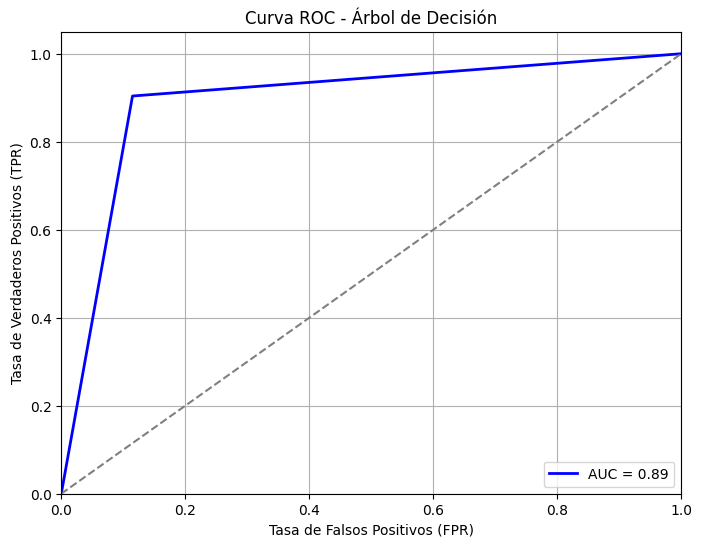

In [15]:
# Obtener probabilidades de predicción
y_probs = pipeline.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Graficar la curva AUC-ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Árbol de Decisión')
plt.legend(loc='lower right')
plt.grid()
plt.show()

🔹 Palabras más influyentes en la predicción:
    Atributo  Importancia
0        per     0.068655
1       equo     0.051756
2     eajpnv     0.040433
3        per     0.039569
4    narbona     0.035646
5       equo     0.034283
6        bng     0.033801
7     eajpnv     0.026350
8    canaria     0.021581
9    maestre     0.021145
10       bng     0.017576
11    garcia     0.013131
12  canarias     0.012637
13     jordi     0.011275
14    prieto     0.010256


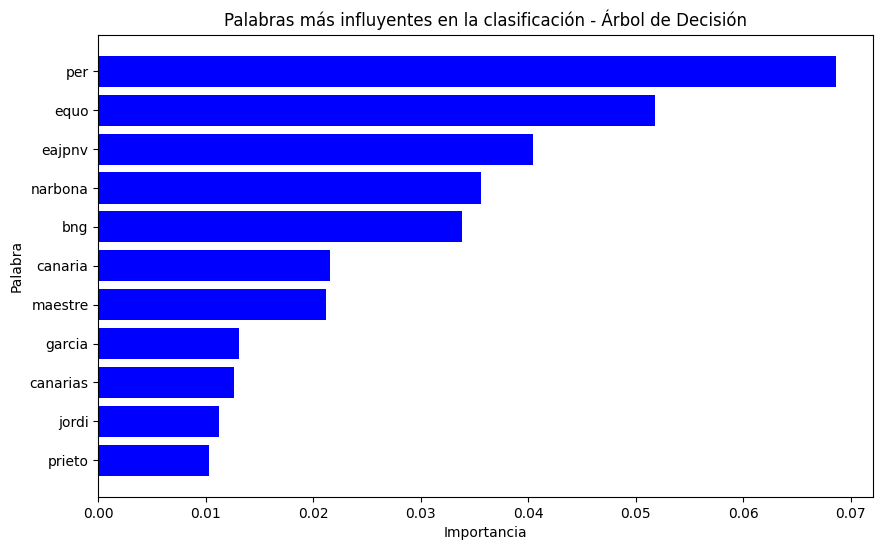

In [19]:

importancia = pipeline.named_steps['classifier'].feature_importances_

# Obtener nombres de las características desde TF-IDF (título y descripción)
vectorizer_title = pipeline.named_steps['features'].named_transformers_['title_tfidf']
vectorizer_desc = pipeline.named_steps['features'].named_transformers_['desc_tfidf']

# Extraer nombres de las palabras de cada vectorizador
feature_names_title = vectorizer_title.get_feature_names_out()
feature_names_desc = vectorizer_desc.get_feature_names_out()

# Combinar los nombres de las características en un solo array
feature_names = np.concatenate([feature_names_title, feature_names_desc])

# Verificar que la cantidad de nombres y coeficientes coincida
assert len(feature_names) == len(importancia), f"Dimensiones no coinciden: {len(feature_names)} != {len(importancia)}"

# Crear un DataFrame con la importancia de cada palabra
importancia_atributo = pd.DataFrame({"Atributo": feature_names, "Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)

# Mostrar las 15 palabras más importantes
print("🔹 Palabras más influyentes en la predicción:")
print(importancia_atributo.head(50))

plt.figure(figsize=(10, 6))
plt.barh(importancia_atributo["Atributo"][:50], importancia_atributo["Importancia"][:50], color='blue')
plt.xlabel("Importancia")
plt.ylabel("Palabra")
plt.title("Palabras más influyentes en la clasificación - Árbol de Decisión")
plt.gca().invert_yaxis()  # Invertir el eje para que la palabra más influyente aparezca arriba
plt.show()


In [20]:
filename = "model_decision_tree.joblib"
dump(pipeline, filename)
pipeline_loaded = load(filename)

In [21]:

# Cargar el modelo previamente guardado
filename = "model_decision_tree.joblib"
pipeline_loaded = load(filename)

# Cargar los datos de prueba
test_data = pd.read_csv('fake_news_test.csv', sep=';', encoding='utf-8')

# Cargar el modelo de español
nlp = spacy.load("es_core_news_sm")

# Suponiendo que data_t es tu DataFrame y tiene la columna 'Descripcion'
# Definimos una función de preprocesamiento con spaCy
def preprocess_text(text):
    # Verificar que el texto no sea NaN
    if not isinstance(text, str):
        return ""
    doc = nlp(text)
    # Procesamos cada token:
    # - Convertimos a minúscula
    # - Extraemos el lema
    # - Eliminamos tokens de puntuación y stopwords
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and token.lemma_ != '-PRON-'
    ]
    return " ".join(tokens)

# Aplicamos la función a la columna 'Descripcion'
test_data['Descripcion_processed'] = test_data['Descripcion'].apply(preprocess_text)
test_data['Titulo_processed'] = test_data['Titulo'].apply(preprocess_text)


# Mostramos algunos resultados
print(test_data[['Descripcion', 'Descripcion_processed', 'Titulo','Titulo_processed']].head())


                                         Descripcion  \
0  Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...   
1  No es la primera vez que los ciudadanos vulner...   
2  El partido morado reprocha que los socialistas...   
3  La renuncia de Felipe VI a su herencia, proced...   
4  El Ejecutivo también prorrogará la suspensión ...   

                               Descripcion_processed  \
0  portavoz ciudadanos pnv upn psoe unidos pp equ...   
1  ciudadano vulnerable topar obstáculo hora soli...   
2  partido morado reprochar socialista tener para...   
3  renuncia felipe vi herencia procedente multimi...   
4  ejecutivo prorrogacer suspensión impuesto gene...   

                                              Titulo  \
0  La mesa del congreso censura un encuentro inte...   
1  La brecha digital que dificulta el acceso de a...   
2  PP apremia al EQUO a presentar una propuesta d...   
3  De soberano garante de la democracia a rey cor...   
4  El Gobierno aprobará este martes detraer lo

In [22]:
# Función para tokenizar el texto procesado (dividir en tokens)
def tokenize_text(text):
    return text.split()

# Aplicamos la tokenización sobre el texto preprocesado
test_data['Tokens_Descripcion'] = test_data['Descripcion_processed'].apply(tokenize_text)
test_data['Tokens_Titulo'] = test_data['Titulo_processed'].apply(tokenize_text)


# Mostramos algunos resultados
print(test_data[['Descripcion','Tokens_Descripcion', 'Titulo','Tokens_Titulo']].head())

test_data['Tokens_Descripcion'].dropna()
test_data['Tokens_Titulo'].dropna()

                                         Descripcion  \
0  Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...   
1  No es la primera vez que los ciudadanos vulner...   
2  El partido morado reprocha que los socialistas...   
3  La renuncia de Felipe VI a su herencia, proced...   
4  El Ejecutivo también prorrogará la suspensión ...   

                                  Tokens_Descripcion  \
0  [portavoz, ciudadanos, pnv, upn, psoe, unidos,...   
1  [ciudadano, vulnerable, topar, obstáculo, hora...   
2  [partido, morado, reprochar, socialista, tener...   
3  [renuncia, felipe, vi, herencia, procedente, m...   
4  [ejecutivo, prorrogacer, suspensión, impuesto,...   

                                              Titulo  \
0  La mesa del congreso censura un encuentro inte...   
1  La brecha digital que dificulta el acceso de a...   
2  PP apremia al EQUO a presentar una propuesta d...   
3  De soberano garante de la democracia a rey cor...   
4  El Gobierno aprobará este martes detraer lo

0      [mesa, congreso, censurar, encuentro, internac...
1      [brecha, digital, dificultar, acceso, ayuda, p...
2      [pp, apremiar, equo, presentar, propuesta, gob...
3      [soberano, garante, democracia, rey, corrupto,...
4      [gobierno, aprobar, martes, detraer, beneficio...
                             ...                        
995    [irenir, montero, feminismo, único, propuesta,...
996    [cospedal, encargar, villarejo, espiar, herman...
997    [esquerra, unida, i, alternativa, miquel, puey...
998     [valls, pp, ciudadanos, apoyar, forma, gobierno]
999    [deportado, vasco, buscar, volver, euskadi, ví...
Name: Tokens_Titulo, Length: 1000, dtype: object

In [23]:
test_data['Words_Descripcion']=test_data['Tokens_Descripcion'].apply(preprocessing)
test_data['Words_Titulo']=test_data['Tokens_Titulo'].apply(preprocessing)

test_data


,ID,Titulo,Descripcion,Fecha,Descripcion_processed,Titulo_processed,Tokens_Descripcion,Tokens_Titulo,Words_Descripcion,Words_Titulo
0,ID,La mesa del congreso censura un encuentro inte...,"Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...",30/10/2018,portavoz ciudadanos pnv upn psoe unidos pp equ...,mesa congreso censurar encuentro internacional...,"[portavoz, ciudadanos, pnv, upn, psoe, unidos,...","[mesa, congreso, censurar, encuentro, internac...","[portavoz, ciudadanos, pnv, upn, psoe, unidos,...","[mesa, congreso, censurar, encuentro, internac..."
1,ID,La brecha digital que dificulta el acceso de a...,No es la primera vez que los ciudadanos vulner...,15/03/2023,ciudadano vulnerable topar obstáculo hora soli...,brecha digital dificultar acceso ayuda persona...,"[ciudadano, vulnerable, topar, obstáculo, hora...","[brecha, digital, dificultar, acceso, ayuda, p...","[ciudadano, vulnerable, topar, obstaculo, hora...","[brecha, digital, dificultar, acceso, ayuda, p..."
2,ID,PP apremia al EQUO a presentar una propuesta d...,El partido morado reprocha que los socialistas...,01/07/2019,partido morado reprochar socialista tener para...,pp apremiar equo presentar propuesta gobierno ...,"[partido, morado, reprochar, socialista, tener...","[pp, apremiar, equo, presentar, propuesta, gob...","[partido, morado, reprochar, socialista, tener...","[pp, apremiar, equo, presentar, propuesta, gob..."
3,ID,De soberano garante de la democracia a rey cor...,"La renuncia de Felipe VI a su herencia, proced...",16/03/2020,renuncia felipe vi herencia procedente multimi...,soberano garante democracia rey corrupto apart...,"[renuncia, felipe, vi, herencia, procedente, m...","[soberano, garante, democracia, rey, corrupto,...","[renuncia, felipe, vi, herencia, procedente, m...","[soberano, garante, democracia, rey, corrupto,..."
4,ID,El Gobierno aprobará este martes detraer los b...,El Ejecutivo también prorrogará la suspensión ...,13/09/2021,ejecutivo prorrogacer suspensión impuesto gene...,gobierno aprobar martes detraer beneficio extr...,"[ejecutivo, prorrogacer, suspensión, impuesto,...","[gobierno, aprobar, martes, detraer, beneficio...","[ejecutivo, prorrogacer, suspension, impuesto,...","[gobierno, aprobar, martes, detraer, beneficio..."
...,...,...,...,...,...,...,...,...,...,...
995,ID,Irene Montero: 'El feminismo es la única propu...,La portavoz de Unidos Podemos asegura que ha c...,21/02/2019,portavoz unidos asegurar comenzar precampaña b...,irenir montero feminismo único propuesta ganad...,"[portavoz, unidos, asegurar, comenzar, precamp...","[irenir, montero, feminismo, único, propuesta,...","[portavoz, unidos, asegurar, comenzar, precamp...","[irenir, montero, feminismo, unico, propuesta,..."
996,ID,Cospedal encargó a Villarejo espiar al hermano...,El comisario encarcelado relata en una de sus ...,05/11/2018,comisario encarcelado relatar grabación exnúme...,cospedal encargar villarejo espiar hermano rub...,"[comisario, encarcelado, relatar, grabación, e...","[cospedal, encargar, villarejo, espiar, herman...","[comisario, encarcelado, relatar, grabacion, e...","[cospedal, encargar, villarejo, espiar, herman..."
997,ID,El Esquerra Unida i Alternativa de Miquel Puey...,Los nacionalistas esperan aprovechar la debili...,26/04/2023,nacionalista esperar aprovechar debilidad cana...,esquerra unida i alternativa miquel pueyo usar...,"[nacionalista, esperar, aprovechar, debilidad,...","[esquerra, unida, i, alternativa, miquel, puey...","[nacionalista, esperar, aprovechar, debilidad,...","[esquerra, unida, i, alternativa, miquel, puey..."
998,ID,Valls: 'PP y Ciudadanos deben apoyar de una fo...,Un partido liberal progresista como Cs no pued...,30/06/2019,partido liberal progresista cs pactar vox ensu...,valls pp ciudadanos apoyar forma gobierno,"[partido, liberal, progresista, cs, pactar, vo...","[valls, pp, ciudadanos, apoyar, forma, gobierno]","[partido, liberal, progresista, cs, pactar, vo...","[valls, pp, ciudadanos, apoyar, forma, gobierno]"


In [24]:
# Verificar que las columnas correctas existen en los datos de prueba
if 'Words_Titulo' in test_data.columns and 'Words_Descripcion' in test_data.columns:
    # Convertir listas en cadenas de texto si es necesario
    test_data["Words_Titulo"] = test_data["Words_Titulo"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
    test_data["Words_Descripcion"] = test_data["Words_Descripcion"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)

    # Realizar predicciones
    predictions = pipeline_loaded.predict(test_data[['Words_Titulo', 'Words_Descripcion']])

    # Guardar los resultados en un nuevo CSV
    test_data["Label"] = predictions

    #Borrar las columnas de texto procesado
    test_data.drop(columns=['Descripcion_processed', 'Titulo_processed', 'Tokens_Descripcion', 'Tokens_Titulo','Words_Titulo','Words_Descripcion'], inplace=True)
    test_data.to_csv("fake_news_predictions_decision_tree.csv", index=False)

    print("Predicciones guardadas en 'fake_news_predictions_decision_tree.csv'")
else:
    print("Error: Las columnas 'Words_Titulo' y 'Words_Descripcion' no están en el archivo de prueba.")

Predicciones guardadas en 'fake_news_predictions_decision_tree.csv'




## Entrenamiento de la regresión Logística

Se crea un pipeline para procesar el texto y entrenar un modelo de regresión logística para la clasificación de noticias.

In [25]:


# Separar variables predictoras y variable objetivo
X = data_t[['Words_Titulo', 'Words_Descripcion']]
y = data_t['Label']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

# Pipeline de preprocesamiento que incluye las características de texto
preprocessor = ColumnTransformer([
    ('title_tfidf', TfidfVectorizer(), 'Words_Titulo'),
    ('desc_tfidf', TfidfVectorizer(), 'Words_Descripcion')
])

# Pipeline completo con regresión logística
pipeline = Pipeline([
    ('features', preprocessor),
    ('classifier', LogisticRegression())
])

# Entrenar el modelo
pipeline.fit(X_train, y_train)



Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('title_tfidf',
                                                  TfidfVectorizer(),
                                                  'Words_Titulo'),
                                                 ('desc_tfidf',
                                                  TfidfVectorizer(),
                                                  'Words_Descripcion')])),
                ('classifier', LogisticRegression())])

#### Evaluación del Modelo

Se evalúa el desempeño del modelo en el conjunto de prueba utilizando métricas como precisión, recall y matriz de confusión.

In [26]:

# Realizar las predicciones en el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Calcular la matriz de confusión
# En la matriz, se asume la siguiente estructura:
# [[TN, FP],
#  [FN, TP]]
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

# Calcular las métricas
# Exactitud (Accuracy): (VP + VN) / Total
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Error: (FP + FN) / Total
error_rate = (FP + FN) / (TP + TN + FP + FN)

# Precisión: VP / (VP + FP)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

# Sensibilidad o Recall: VP / (VP + FN)
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# Especificidad: VN / (VN + FP)
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

# F1-Score: 2 * (precision * recall) / (precision + recall)
f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Imprimir las métricas
print("Métricas del modelo:")
print(f"Exactitud (Accuracy): {accuracy:.2f}")
print(f"Error: {error_rate:.2f}")
print(f"Precisión (Precision): {precision:.2f}")
print(f"Sensibilidad (Recall): {recall:.2f}")
print(f"Especificidad: {specificity:.2f}")
print(f"F1-Score: {f1_score:.2f}")


Métricas del modelo:
Exactitud (Accuracy): 0.89
Error: 0.11
Precisión (Precision): 0.87
Sensibilidad (Recall): 0.95
Especificidad: 0.80
F1-Score: 0.91


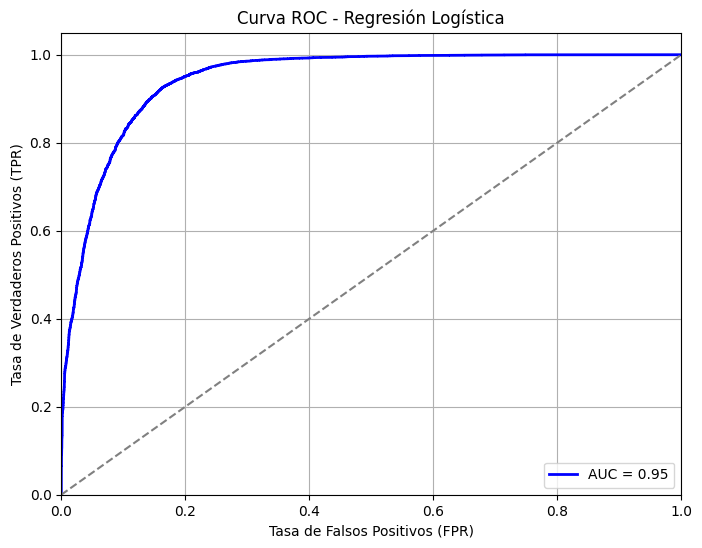

In [27]:
# Obtener probabilidades de predicción
y_probs = pipeline.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Graficar la curva AUC-ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Regresión Logística')
plt.legend(loc='lower right')
plt.grid()
plt.show()

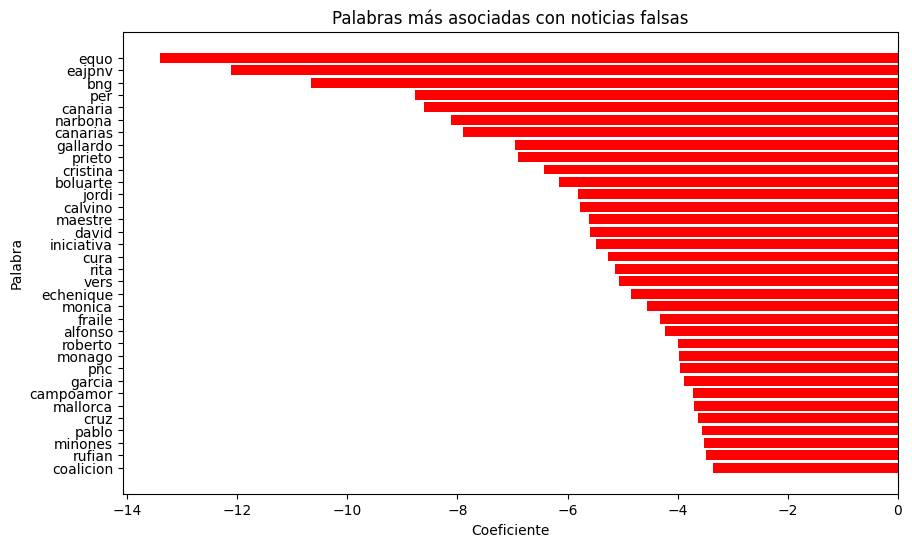

In [28]:
# Obtener las transformaciones de ColumnTransformer
vectorizer_titulo = pipeline.named_steps['features'].named_transformers_['title_tfidf']
vectorizer_desc = pipeline.named_steps['features'].named_transformers_['desc_tfidf']

# Obtener los nombres de las palabras procesadas en cada vectorizador
feature_names_titulo = vectorizer_titulo.get_feature_names_out()
feature_names_desc = vectorizer_desc.get_feature_names_out()

# Combinar todas las palabras
feature_names = np.concatenate([feature_names_titulo, feature_names_desc])

# Obtener los coeficientes del modelo de regresión logística
coefs = pipeline.named_steps['classifier'].coef_[0]

# Verificar que las longitudes coincidan
assert len(feature_names) == len(coefs), f"Dimensiones no coinciden: {len(feature_names)} != {len(coefs)}"

# Crear un DataFrame con palabras y sus coeficientes
word_importance = pd.DataFrame({'Palabra': feature_names, 'Coeficiente': coefs})

# Ordenar palabras más asociadas con noticias falsas (coeficiente más negativo)
top_false_words = word_importance.sort_values(by='Coeficiente', ascending=True).head(50)

# Graficar las palabras más asociadas con noticias falsas
plt.figure(figsize=(10, 6))
plt.barh(top_false_words['Palabra'], top_false_words['Coeficiente'], color='red')
plt.xlabel('Coeficiente')
plt.ylabel('Palabra')
plt.title('Palabras más asociadas con noticias falsas')
plt.gca().invert_yaxis()  # Invertir eje para mostrar la palabra más relevante arriba
plt.show()


In [29]:
filename = "model_logistic_regression.joblib"
dump(pipeline, filename)
pipeline_loaded = load(filename)

In [30]:

# Cargar el modelo previamente guardado
filename = "model_logistic_regression.joblib"
pipeline_loaded = load(filename)

# Cargar los datos de prueba
test_data = pd.read_csv('fake_news_test.csv', sep=';', encoding='utf-8')

# Cargar el modelo de español
nlp = spacy.load("es_core_news_sm")

# Suponiendo que data_t es tu DataFrame y tiene la columna 'Descripcion'
# Definimos una función de preprocesamiento con spaCy
def preprocess_text(text):
    # Verificar que el texto no sea NaN
    if not isinstance(text, str):
        return ""
    doc = nlp(text)
    # Procesamos cada token:
    # - Convertimos a minúscula
    # - Extraemos el lema
    # - Eliminamos tokens de puntuación y stopwords
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and token.lemma_ != '-PRON-'
    ]
    return " ".join(tokens)

# Aplicamos la función a la columna 'Descripcion'
test_data['Descripcion_processed'] = test_data['Descripcion'].apply(preprocess_text)
test_data['Titulo_processed'] = test_data['Titulo'].apply(preprocess_text)


# Mostramos algunos resultados
print(test_data[['Descripcion', 'Descripcion_processed', 'Titulo','Titulo_processed']].head())


                                         Descripcion  \
0  Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...   
1  No es la primera vez que los ciudadanos vulner...   
2  El partido morado reprocha que los socialistas...   
3  La renuncia de Felipe VI a su herencia, proced...   
4  El Ejecutivo también prorrogará la suspensión ...   

                               Descripcion_processed  \
0  portavoz ciudadanos pnv upn psoe unidos pp equ...   
1  ciudadano vulnerable topar obstáculo hora soli...   
2  partido morado reprochar socialista tener para...   
3  renuncia felipe vi herencia procedente multimi...   
4  ejecutivo prorrogacer suspensión impuesto gene...   

                                              Titulo  \
0  La mesa del congreso censura un encuentro inte...   
1  La brecha digital que dificulta el acceso de a...   
2  PP apremia al EQUO a presentar una propuesta d...   
3  De soberano garante de la democracia a rey cor...   
4  El Gobierno aprobará este martes detraer lo

In [31]:
# Función para tokenizar el texto procesado (dividir en tokens)
def tokenize_text(text):
    return text.split()

# Aplicamos la tokenización sobre el texto preprocesado
test_data['Tokens_Descripcion'] = test_data['Descripcion_processed'].apply(tokenize_text)
test_data['Tokens_Titulo'] = test_data['Titulo_processed'].apply(tokenize_text)


# Mostramos algunos resultados
print(test_data[['Descripcion','Tokens_Descripcion', 'Titulo','Tokens_Titulo']].head())

test_data['Tokens_Descripcion'].dropna()
test_data['Tokens_Titulo'].dropna()

                                         Descripcion  \
0  Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...   
1  No es la primera vez que los ciudadanos vulner...   
2  El partido morado reprocha que los socialistas...   
3  La renuncia de Felipe VI a su herencia, proced...   
4  El Ejecutivo también prorrogará la suspensión ...   

                                  Tokens_Descripcion  \
0  [portavoz, ciudadanos, pnv, upn, psoe, unidos,...   
1  [ciudadano, vulnerable, topar, obstáculo, hora...   
2  [partido, morado, reprochar, socialista, tener...   
3  [renuncia, felipe, vi, herencia, procedente, m...   
4  [ejecutivo, prorrogacer, suspensión, impuesto,...   

                                              Titulo  \
0  La mesa del congreso censura un encuentro inte...   
1  La brecha digital que dificulta el acceso de a...   
2  PP apremia al EQUO a presentar una propuesta d...   
3  De soberano garante de la democracia a rey cor...   
4  El Gobierno aprobará este martes detraer lo

0      [mesa, congreso, censurar, encuentro, internac...
1      [brecha, digital, dificultar, acceso, ayuda, p...
2      [pp, apremiar, equo, presentar, propuesta, gob...
3      [soberano, garante, democracia, rey, corrupto,...
4      [gobierno, aprobar, martes, detraer, beneficio...
                             ...                        
995    [irenir, montero, feminismo, único, propuesta,...
996    [cospedal, encargar, villarejo, espiar, herman...
997    [esquerra, unida, i, alternativa, miquel, puey...
998     [valls, pp, ciudadanos, apoyar, forma, gobierno]
999    [deportado, vasco, buscar, volver, euskadi, ví...
Name: Tokens_Titulo, Length: 1000, dtype: object

In [32]:
test_data['Words_Descripcion']=test_data['Tokens_Descripcion'].apply(preprocessing)
test_data['Words_Titulo']=test_data['Tokens_Titulo'].apply(preprocessing)

test_data


,ID,Titulo,Descripcion,Fecha,Descripcion_processed,Titulo_processed,Tokens_Descripcion,Tokens_Titulo,Words_Descripcion,Words_Titulo
0,ID,La mesa del congreso censura un encuentro inte...,"Portavoces de Ciudadanos, PNV, UPN, PSOE, Unid...",30/10/2018,portavoz ciudadanos pnv upn psoe unidos pp equ...,mesa congreso censurar encuentro internacional...,"[portavoz, ciudadanos, pnv, upn, psoe, unidos,...","[mesa, congreso, censurar, encuentro, internac...","[portavoz, ciudadanos, pnv, upn, psoe, unidos,...","[mesa, congreso, censurar, encuentro, internac..."
1,ID,La brecha digital que dificulta el acceso de a...,No es la primera vez que los ciudadanos vulner...,15/03/2023,ciudadano vulnerable topar obstáculo hora soli...,brecha digital dificultar acceso ayuda persona...,"[ciudadano, vulnerable, topar, obstáculo, hora...","[brecha, digital, dificultar, acceso, ayuda, p...","[ciudadano, vulnerable, topar, obstaculo, hora...","[brecha, digital, dificultar, acceso, ayuda, p..."
2,ID,PP apremia al EQUO a presentar una propuesta d...,El partido morado reprocha que los socialistas...,01/07/2019,partido morado reprochar socialista tener para...,pp apremiar equo presentar propuesta gobierno ...,"[partido, morado, reprochar, socialista, tener...","[pp, apremiar, equo, presentar, propuesta, gob...","[partido, morado, reprochar, socialista, tener...","[pp, apremiar, equo, presentar, propuesta, gob..."
3,ID,De soberano garante de la democracia a rey cor...,"La renuncia de Felipe VI a su herencia, proced...",16/03/2020,renuncia felipe vi herencia procedente multimi...,soberano garante democracia rey corrupto apart...,"[renuncia, felipe, vi, herencia, procedente, m...","[soberano, garante, democracia, rey, corrupto,...","[renuncia, felipe, vi, herencia, procedente, m...","[soberano, garante, democracia, rey, corrupto,..."
4,ID,El Gobierno aprobará este martes detraer los b...,El Ejecutivo también prorrogará la suspensión ...,13/09/2021,ejecutivo prorrogacer suspensión impuesto gene...,gobierno aprobar martes detraer beneficio extr...,"[ejecutivo, prorrogacer, suspensión, impuesto,...","[gobierno, aprobar, martes, detraer, beneficio...","[ejecutivo, prorrogacer, suspension, impuesto,...","[gobierno, aprobar, martes, detraer, beneficio..."
...,...,...,...,...,...,...,...,...,...,...
995,ID,Irene Montero: 'El feminismo es la única propu...,La portavoz de Unidos Podemos asegura que ha c...,21/02/2019,portavoz unidos asegurar comenzar precampaña b...,irenir montero feminismo único propuesta ganad...,"[portavoz, unidos, asegurar, comenzar, precamp...","[irenir, montero, feminismo, único, propuesta,...","[portavoz, unidos, asegurar, comenzar, precamp...","[irenir, montero, feminismo, unico, propuesta,..."
996,ID,Cospedal encargó a Villarejo espiar al hermano...,El comisario encarcelado relata en una de sus ...,05/11/2018,comisario encarcelado relatar grabación exnúme...,cospedal encargar villarejo espiar hermano rub...,"[comisario, encarcelado, relatar, grabación, e...","[cospedal, encargar, villarejo, espiar, herman...","[comisario, encarcelado, relatar, grabacion, e...","[cospedal, encargar, villarejo, espiar, herman..."
997,ID,El Esquerra Unida i Alternativa de Miquel Puey...,Los nacionalistas esperan aprovechar la debili...,26/04/2023,nacionalista esperar aprovechar debilidad cana...,esquerra unida i alternativa miquel pueyo usar...,"[nacionalista, esperar, aprovechar, debilidad,...","[esquerra, unida, i, alternativa, miquel, puey...","[nacionalista, esperar, aprovechar, debilidad,...","[esquerra, unida, i, alternativa, miquel, puey..."
998,ID,Valls: 'PP y Ciudadanos deben apoyar de una fo...,Un partido liberal progresista como Cs no pued...,30/06/2019,partido liberal progresista cs pactar vox ensu...,valls pp ciudadanos apoyar forma gobierno,"[partido, liberal, progresista, cs, pactar, vo...","[valls, pp, ciudadanos, apoyar, forma, gobierno]","[partido, liberal, progresista, cs, pactar, vo...","[valls, pp, ciudadanos, apoyar, forma, gobierno]"


In [33]:
# Verificar que las columnas correctas existen en los datos de prueba
if 'Words_Titulo' in test_data.columns and 'Words_Descripcion' in test_data.columns:
    # Convertir listas en cadenas de texto si es necesario
    test_data["Words_Titulo"] = test_data["Words_Titulo"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
    test_data["Words_Descripcion"] = test_data["Words_Descripcion"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)

    # Realizar predicciones
    predictions = pipeline_loaded.predict(test_data[['Words_Titulo', 'Words_Descripcion']])

    # Guardar los resultados en un nuevo CSV
    test_data["Label"] = predictions

    #Borrar las columnas de texto procesado
    test_data.drop(columns=['Descripcion_processed', 'Titulo_processed', 'Tokens_Descripcion', 'Tokens_Titulo','Words_Titulo','Words_Descripcion'], inplace=True)
    test_data.to_csv("fake_news_predictions_logistic_regression.csv", index=False)

    print("Predicciones guardadas en 'fake_news_predictions_logistic_regression.csv'")
else:
    print("Error: Las columnas 'Words_Titulo' y 'Words_Descripcion' no están en el archivo de prueba.")

Predicciones guardadas en 'fake_news_predictions_logistic_regression.csv'
